# NLP for Customer Reviews

## Using Logistic Regression

Our project owners would like to know about if a review is positive or negative. Ideally, they'd like to know why the review was positive or negative.

Since the response (dependent) variable (sentiment) is categorical (nominal), the problem at hand is labeled as a classification problem. Our goal is to attempt to classify each observation (review) into a cateogry (aka, class).

We will construct a Logistic Regression model to predict the sentiment of a product review from a customer.

### General Outline

* [Step 0](#step0). Setting the notebook
* [Step 1](#step1). Importing the data
* [Step 2](#step2). Exploring the data
* [Step 3](#step3). Cleaning the data
* [Step 4](#step4). Preparing and splitting the data
* [Step 5](#step5). Vectorizing the features
* [Step 6](#step6). Modeling Logistic Regression
* [Step 7](#step7). Extracting feature importance

<a id='step0'></a>
## Step 0: Setting up the notebook

In [183]:
# Install packages
!pip install -q wordcloud
!pip install -q nltk
!pip install -q wget

In [2]:
# Data and Stats packages
import wget
import os
import math
import pandas as pd
import numpy as np
from sklearn.utils import shuffle

# Visualization packages
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline

# NLP processing packages
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Machine Learning packages
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Aesthetic settings
import warnings
warnings.filterwarnings('ignore')

<a id='step1'></a>
## Step 1: Importing the data

In [3]:
# Data url
reviews_url = 'https://s3.amazonaws.com/fast-ai-nlp/amazon_review_polarity_csv.tgz'

# Download the data to current directory
wget.download(reviews_url, './amazon_review_polarity_csv.tgz')

# Unzip the data
!tar -xvzf amazon_review_polarity_csv.tgz

# Delete the tgz file
os.remove('amazon_review_polarity_csv.tgz')

x amazon_review_polarity_csv/
x amazon_review_polarity_csv/train.csv
x amazon_review_polarity_csv/readme.txt
x amazon_review_polarity_csv/test.csv


In [189]:
# Define paths to data sets
DATA = 'amazon_review_polarity_csv'

TRAIN_DIR = os.path.join(DATA, 'train.csv')
TEST_DIR = os.path.join(DATA, 'test.csv')

In [190]:
# Load train and test data into dataframe
col_names = ["label", "title", "review"]
data_train = pd.read_csv(TRAIN_DIR, names=col_names)
data_test = pd.read_csv(TEST_DIR, names=col_names)

print("Amazon reviews: train = {:,}, test = {:,}".format(len(data_train), len(data_test)))

Amazon reviews: train = 3,600,000, test = 400,000


<a id='step2'></a>
## Step 2: Exploring the data

In [191]:
# Check data types
data_train.dtypes

label      int64
title     object
review    object
dtype: object

In [192]:
# Train data overview
data_train.head()

,label,title,review
0,2,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...
1,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
2,2,Amazing!,This soundtrack is my favorite music of all ti...
3,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
4,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."


In [193]:
print("Train set label counts:")
display(data_train.label.value_counts())

print("Test set label counts:")
data_test.label.value_counts()

Train set label counts:


2    1800000
1    1800000
Name: label, dtype: int64

Test set label counts:


2    200000
1    200000
Name: label, dtype: int64

In [43]:
# Positive review
pos_review = data_train[data_train.label == 2].iloc[0]
print(pos_review.title)
print(pos_review.review)

Stuning even for the non-gamer
This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^


In [44]:
# Negative review
neg_review = data_train[data_train.label == 1].iloc[0]
print(neg_review.title)
print(neg_review.review)

Buyer beware
This is a self-published book, and if you want to know why--read a few paragraphs! Those 5 star reviews must have been written by Ms. Haddon's family and friends--or perhaps, by herself! I can't imagine anyone reading the whole thing--I spent an evening with the book and a friend and we were in hysterics reading bits and pieces of it to one another. It is most definitely bad enough to be entered into some kind of a "worst book" contest. I can't believe Amazon even sells this kind of thing. Maybe I can offer them my 8th grade term paper on "To Kill a Mockingbird"--a book I am quite sure Ms. Haddon never heard of. Anyway, unless you are in a mood to send a book to someone as a joke---stay far, far away from this one!


In [61]:
def sample_reviews(df, label, n_samples):
    """
    Return randomly sampled reviews.
    """
    # Sample reviews
    review_df = df[df['label'] == label].sample(N_SAMPLES)
    # Concat the title and content of review
    review_list = []
    for idx, pos in review_df.iterrows():
        review_list.append(str(pos['title']) + ' ' + str(pos['review']))
    # Return a string representation of all reviews
    return ' '.join(review_list)

def display_wordcloud(words, stop_words, title):
    """
    Visualize word cloud (aka, most commonly used words)
    """
    # Create a word cloud object
    wc = WordCloud(
        background_color='white', max_words=50, stopwords=STOPWORDS.update(stop_words)
    )
    # Generate and plot pos wordcloud
    plt.figure(figsize=(10,10))
    plt.imshow(wc.generate(words))
    plt.axis('off')
    plt.title(title, fontsize=12)
    plt.show();

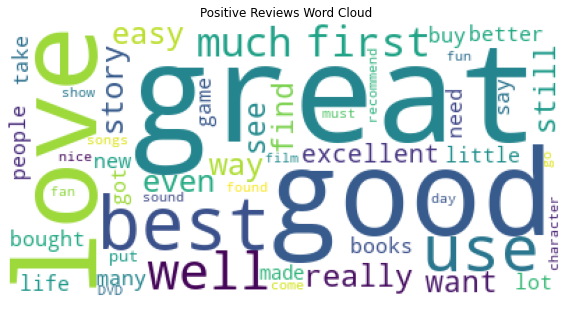

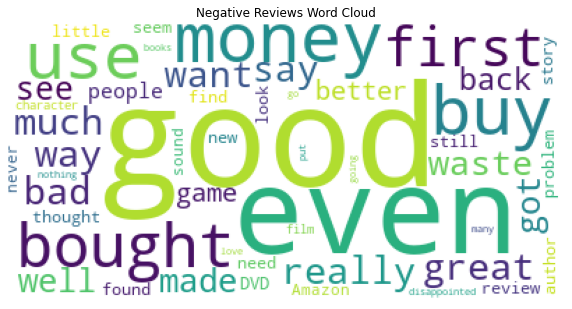

In [64]:
# Sample positive reviews
pos_reviews = sample_reviews(data_train, 2, 50000)

# Sampel negative reviews
neg_reviews = sample_reviews(data_train, 1, 50000)

# Display positive word cloud
stop_words = [
    'book', 'movie', 'song', 'product', 'CD', 'time', 'make', 'album', 'thing',
    'one', 'will', 'work', 'music', 'know', 'used', 'now', 'give', 'think', 'read']
display_wordcloud(pos_reviews, stop_words, 'Positive Reviews Word Cloud')

# Display negative word cloud
display_wordcloud(neg_reviews, stop_words, 'Negative Reviews Word Cloud')

<a id='step3'></a>
## Step 3: Cleaning the data

In [153]:
# Concat title and review
data_train['title_and_review'] = \
    data_train['title'].astype('str') + ' ' + data_train['review'].astype('str')
data_test['title_and_review'] = \
    data_test['title'].astype('str') + ' ' + data_test['review'].astype('str')

In [154]:
data_train.iloc[0]

label                                                               2
title                                  Stuning even for the non-gamer
review              This sound track was beautiful! It paints the ...
title_and_review    Stuning even for the non-gamer This sound trac...
Name: 0, dtype: object

In [155]:
data_train['title_and_review'][0]

'Stuning even for the non-gamer This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^'

### What is inflection?

"In grammar, inflection is the modification of a word to express different grammatical categories such as **tense, case, voice, aspect, person, number, gender, and mood**. An inflection expresses one or more grammatical categories with a **prefix, suffix or infix**, or another internal modification such as a vowel change" [Wikipedia]

### What is lemmtization?

"Lemmatization in linguistics is the process of **grouping together the inflected forms** of a word so they can be analysed as a single item, identified by the word's lemma, or dictionary form." [Wikipedia]

![](https://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1539984207/stemminglemmatization_n8bmou.jpg)

Adapted from [Hafsa Jabeen](https://www.datacamp.com/community/tutorials/stemming-lemmatization-python)

In [156]:
# Create a lemmatizer object
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

# Create a set of stop words
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Add more extra stop words
stop_words |= {
    'book', 'movie', 'song', 'product', 'music', 'CD', 'time', 'make', 'album', 'thing'
    }

# Punctuation to be removed
punc = '[!"#$%&\'()*+,-./:;<=>?@[\\]`{|}~]'

def normalize_text(text):
    """
    Lowercase, remove punctualiont, tokenize, 
    lemmatize and remove stop words and words whose length is less than 3"""
    text = re.sub(punc, '', text.lower())
    # Tokenization and lemmatization
    lemmetized_text = [
        lemmatizer.lemmatize(lemmatizer.lemmatize(word,'n'),'v') for word in text.split(' ')
        ]
    # Remove stop words and words whose length is less than 3
    return ' '.join([
        word for word in lemmetized_text if len(word) > 2 and word not in stop_words])

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HONGW\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HONGW\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [162]:
# Preprocess train and test data
data_train['norm_text'] = data_train['title_and_review'].map(normalize_text)
data_test['norm_text'] = data_test['title_and_review'].map(normalize_text)

In [163]:
print(data_train['title_and_review'][0])

Stuning even for the non-gamer This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^


In [164]:
print(data_train['norm_text'][0])

stun even nongamer sound track beautiful paint senery mind well would recomend even people hate vid game play game chrono cross game ever play best back away crude keyboarding take fresher step grate guitar soulful orchestra would impress anyone care listen ^_^


<a id='step4'></a>
## Step 4: Preparing and splitting the data

In [166]:
# Split data into features and labels
features_train, labels_train = data_train.norm_text, data_train.label
features_test, labels_test = data_test.norm_text, data_test.label

# Shuffle data (common practice)
features_train, labels_train = shuffle(features_train, labels_train, random_state=0)
features_test, labels_test = shuffle(features_test, labels_test, random_state=0)

# Split the train data into train and validation set
features_train, features_val = \
    features_train[:-len(features_test)], features_train[-len(features_test):]
labels_train, labels_val = \
    labels_train[:-len(features_test)], labels_train[-len(features_test):]

# Sanity check
assert len(features_train) + len(features_val) == len(data_train)
assert len(features_val) == len(features_test)

print(
    'train features = {} train labels = {}'.format(len(features_train), len(labels_train)))
print(
    'validation features = {} validation labels = {}'.format(len(features_val), len(labels_val)))
print(
    'test features = {} test labels = {}'.format(len(features_test), len(labels_test)))

train features = 3200000 train labels = 3200000
validation features = 400000 validation labels = 400000
test features = 400000 test labels = 400000


In [167]:
# Save features to .csv file
features_train.to_csv(os.path.join(DATA, 'features_train.csv'), header=False, index=False)
features_val.to_csv(os.path.join(DATA, 'features_val.csv'), header=False, index=False)
features_test.to_csv(os.path.join(DATA, 'features_test.csv'), header=False, index=False)

# Save labels to .csv file
labels_train.to_csv(os.path.join(DATA, 'labels_train.csv'), header=False, index=False)
labels_val.to_csv(os.path.join(DATA, 'labels_val.csv'), header=False, index=False)
labels_test.to_csv(os.path.join(DATA, 'labels_test.csv'), header=False, index=False)

<a id='step5'></a>
## Step 5: Vectorizing the features

### What is tf-idf?

"In information retrieval, **tf–idf or TFIDF**, short for **term frequency–inverse document frequency**, is **a numerical statistic** that is intended to **reflect how important a word is** to a document in a collection or corpus." [Wikipedia]

* **term frequency (tf)** is a measure of the frequency of a term within a document.

* **inverse document frequency (tf)** is a measure of the rarity of a term across documents.

**tf-idf(t, d) = tf(t,d) * idf(t)**

* **tf(t, d)** is the number of times a term **t** occurs in a given document **d**
* **idf(t)** is computed as 

$$ idf(t) = log\frac{(1 + n)}{1 + df(t)} + 1 $$

where **n** is the total number of documents in the document set, and **df(t)** is the number of documents in the document set that contain term **t**. [scikit-learn.org]

In [169]:
# Create tfidf vectorizer
vectorizer = TfidfVectorizer(max_features=5000, lowercase=False)

# Fit and transform train features
X_train = vectorizer.fit_transform(features_train)

# Transform validation features
X_val = vectorizer.transform(features_val)

# Transform test features
X_test = vectorizer.transform(features_test)

<a id='step6'></a>
## Step 6: Modeling Logistic Regression

The logistic (sigmoid) function formula: 

$$ \sigma(z) = \frac{\mathrm{1} }{\mathrm{1} + e^{-z}}  $$

The weighted sum (aka dot product):

$$ z = \theta^{T}x = \sum_{i=1}^n \theta_{i}x_{i} = \theta_{0}x_{0} + \theta_{1}x_{1} + ... + \theta_{n}x_{n} $$

Logistic (sigmoid) function of weighted sum:

$$ \sigma(\theta^{T}x) = \frac{1}{1 + e^{-\theta^{T}x}} $$

The logistic regression models *conditional likelihood* **P(Y | X)**:

$$ P(Y = 1|X) = \sigma(\theta^{T}x) $$
$$ P(Y = 0|X) = 1 - \sigma(\theta^{T}x) $$

$$ P(y = y|X = x) = \sigma(\theta^{T}x)^{y} . [1 - \theta^{T}x]^{(1-y)} $$

Training:

Determine parameters $\theta$ so that the model estimates high probabilities for positive observations (y = 1) and low probabilities for negative observations (y = 0).

* Logistic Regression cost function (log loss) 

$$ J(\theta) = -\frac{1}{m} \sum_{i=1}^m [y^{(i)}log(\hat{p}^{(i)}) + (1 - y^{(i)}log(1 - \hat{p}^{(i)}]$$

* Logistic Regression cost function partial derivatives

$$ \frac{\partial}{\partial \theta_{j}} J(\theta) = \frac{1}{m} \sum_{i=1}^m [\sigma(\theta^{T}x^{(i)}) - y^{(i)}] x_{j}^{(i)} $$

* Gradient descent

$$ \theta_{j}^{new} = \theta_{j}^{old} - \eta . \frac{\partial^{old}}{\partial \theta_{j}^{old}} J(\theta)^{old} $$

Classify observation with logistic regression:

$$ \hat{y} = \sigma(\theta^{T}x) $$

$$ \hat{y} = 
\begin{cases}
  0 & \text{if }\hat{y} < 0.5\\    
  1 & \text{otherwise}    
\end{cases}
$$

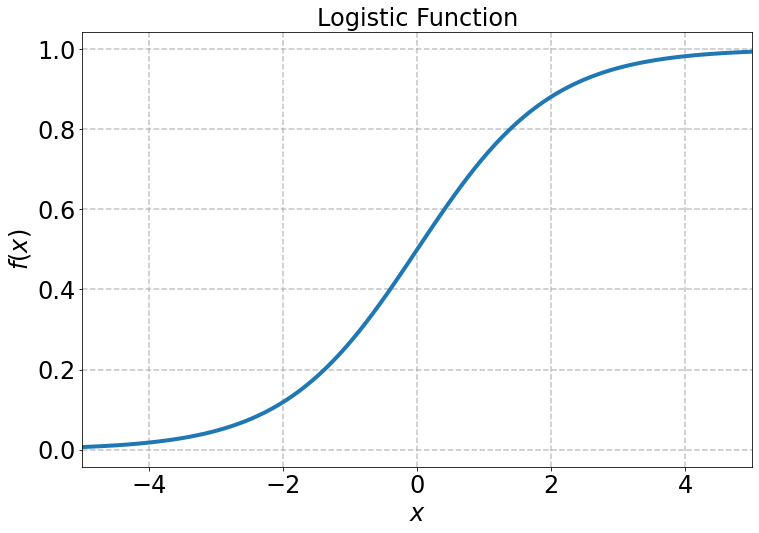

In [181]:
def sigmoid(x):
    return 1.0 / (1 + np.exp(-x))

x = np.linspace(-5, 5, 100)
f = sigmoid(x)

fig, ax = plt.subplots(1,1, figsize=(12,8)) # Make figure bigger

# Make line plot
ax.plot(x, f, lw=4)

# Update ticklabel size
ax.tick_params(labelsize=24)

# Make labels
ax.set_xlabel(r'$x$', fontsize=24)
ax.set_ylabel(r'$f(x)$', fontsize=24)
ax.set_title('Logistic Function', fontsize=24)
ax.set_xlim(-5,5)

ax.grid(True, lw=1.5, ls='--', alpha=0.75)

In [170]:
def evaluate_performance(model, features, labels):
    """
    Evaluate model performance on train, val and test set.
    """
    X_train, X_val, X_test = features[0], features[1], features[2]
    y_tain, y_val, y_test = labels[0], labels[1], labels[2]
    
    # Predicting
    y_pred_train = lr.predict(X_train)
    y_pred_val = lr.predict(X_val)
    y_pred_test = lr.predict(X_test)

    # Evaluating
    train_score = accuracy_score(y_tain, y_pred_train)
    val_score = accuracy_score(y_val, y_pred_val)
    test_score = accuracy_score(y_test, y_pred_test)

    print('Training Set Accuracy:', str(np.round(train_score * 100, 2)) + '%')
    print('Validation Set Accuracy:', str(np.round(val_score * 100, 2)) + '%')
    print('Test Set Accuracy:', str(np.round(test_score * 100, 2)) + '%')

In [173]:
# Training: penalty='l2', C=1.0, max_iter=100
lr = LogisticRegression(random_state=0).fit(X_train, labels_train)

# Evaluating performance
evaluate_performance(lr, [X_train, X_val, X_test], [labels_train, labels_val, labels_test])

Training Set Accuracy: 88.73%
Validation Set Accuracy: 88.67%
Test Set Accuracy: 88.56%


<a id='step7'></a>
## Step 7: Extracting feature importance

In [177]:
# Top 10 posistive and negative words that weight the most
# Credit to Dr. Derick Higgins
pd.options.display.float_format = '{:.4f}'.format

vocab = {idx: w for w, idx in vectorizer.vocabulary_.items()}

word_data = {}
top_features = np.argsort(lr.coef_[0,:])[-1:-11:-1]
coefs = lr.coef_[0,top_features]
words = [vocab[x] for x in top_features]
word_data["pos_beta"] = coefs
word_data["posg_words"] = words

bottom_features = np.argsort(lr.coef_[0,:])[1:11:1]
coefs = lr.coef_[0,bottom_features]
words = [vocab[x] for x in bottom_features]
word_data["neg_beta"] = coefs
word_data["neg_words"] = words

pd.DataFrame(word_data).T

,0,1,2,3,4,5,6,7,8,9
pos_beta,12.2419,11.9513,9.6484,9.6292,8.9286,8.5345,8.2272,8.0872,7.9318,7.8661
posg_words,excellent,great,awesome,pleasantly,perfect,musthave,amaze,highly,invaluable,love
neg_beta,-13.8661,-13.1743,-12.6444,-12.5397,-11.3736,-10.8998,-10.7627,-10.5647,-10.5390,-10.4772
neg_words,waste,disappointment,disappoint,poorly,poor,awful,terrible,worthless,useless,horrible
